# Testing YieldFactorModels Filter Functionality

This notebook tests the filter functions in the YieldFactorModels.jl package.

## 1. Setup and Import

In [1]:
# Add the package to the environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()


  Activating project at `~/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl`
Precompiling project...
   2003.4 ms  ✓ YieldFactorModels
  1 dependency successfully precompiled in 4 seconds. 418 already precompiled.
  1 dependency had output during precompilation:
┌ YieldFactorModels
│  WARNING: method definition for #transform_net_2!#33 at /Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/src/utils/neural_network_transform.jl:282 declares type variable F but does not use it.
└  


## 1.5 Test Performance Improvements

The model has been optimized based on profiling data:
- ✅ Pre-allocated buffers for network outputs
- ✅ Pre-computed maturity transformations  
- ✅ In-place operations in `update_factor_loadings!`
- ✅ Reduced allocations in hot loops

Expected improvements: 15-30% faster, 50% fewer allocations

In [2]:
# Import the package and required dependencies
using Revise
using YieldFactorModels
using LinearAlgebra
using ForwardDiff
using Random

# NOTE: `export VAR=...` is a shell command and is not valid Julia syntax in a code cell.
# For runtime settings that can be changed from within Julia use `ENV` or library APIs.
# Set BLAS / native libraries thread knobs where possible:
ENV["OPENBLAS_NUM_THREADS"] = "1"
ENV["OMP_NUM_THREADS"] = "1"
ENV["MKL_NUM_THREADS"] = "1"  # If MKL.jl is used, prefer MKL.set_num_threads(1)
# Also set BLAS threads from Julia (affects LinearAlgebra.BLAS):
LinearAlgebra.BLAS.set_num_threads(1)

# Important: `JULIA_NUM_THREADS` controls Julia's worker threads and must be
# set before the Julia process / kernel is started. You cannot change the number
# of Julia threads from inside a running kernel. To run the kernel with 1 thread,
# start Jupyter / the kernel with the env var set (see instructions below).

Random.seed!(123)  # For reproducibility


TaskLocalRNG()

In [3]:
cd("..")

## 3. Test Individual Functions

### 3.1 Test `initialize_filter!`

In [4]:
println(pwd())

/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects


In [5]:
data, maturities = load_data("YieldFactorModels.jl/data/", "6")

([7.83403892981863 8.30247299311406 … 4.3268632601382855 4.155682521352292; 7.96778641185185 8.46780405699119 … 4.3328289043004515 4.159368653729067; … ; 10.9519681799619 11.657231239239 … 4.125693391252582 4.537209692896116; 11.371582727334 12.0250709896095 … 4.324326305225288 4.7829716342137685], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  30.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 180.0])

### 3.2 Test `get_β_OLS!`

In [6]:
# Test the OLS estimation function
Z_test = randn(24, 3)
y_test = randn(24)
beta_test = zeros(3)
ZtZ_alloc = similar(Z_test' * Z_test)
Zty_alloc = similar(Z_test' * y_test)

YieldFactorModels.get_β_OLS!(beta_test, Z_test, y_test, ZtZ_alloc, Zty_alloc)

### 3.4 Test Optimziation


In [7]:
float_type = Float64
model, model_type = YieldFactorModels.create_model("3SSD-NNS", maturities,24, 3, float_type, "YieldFactorModels.jl/results/thread_id__6/")
param_groups = YieldFactorModels.get_param_groups(model, String[])
all_params = YieldFactorModels.load_initial_parameters!(model, model_type, float_type)
YieldFactorModels.set_params!(model, all_params[:, 1])
cache = YieldFactorModels.initialize_filter(model)
# Load static parameters if applicable
all_params[:,1] = YieldFactorModels.load_static_parameters!(model, model_type, "YieldFactorModels.jl/results/", "6", all_params[:,1])
# Convert parameters to appropriate float type
all_params = convert(Matrix{float_type}, all_params)
results = predict(model, data[:, 1:end])


Default param groups assigned.


(preds = [7.105818980299407 7.6411683541625255 … 4.1078814422578285 4.119086797964483; 8.307707862166417 8.925321335725755 … 4.074535081776379 4.080232441866857; … ; 10.246774008385048 10.92351283593826 … 3.979150459893648 3.872767163037511; 12.222354026224096 12.19612015409335 … 4.106477751164625 4.473963583759507], factors = [12.222354026224096 12.19612015409335 … 4.106477751164625 4.473963583759507; -5.116535045924689 -4.554951799930825 … 0.0014036910932037588 -0.3548767857950237; -15.604757157886583 -11.92154676913219 … -0.7905800361444879 -1.5081032598515733], states = [-0.6637548353894249 -0.5166738975593986 … 0.35357779320249405 0.30867945826219984; 0.3953851516476877 0.2437680239464998 … 0.04777983004055653 0.01860876260162585; … ; -0.36799361338334463 -0.7668893265091453 … 0.09307334794800064 0.0510626922652371; -0.03367373749535906 0.05614249709471971 … 0.004399680775163463 -0.0009736680071030564], factor_loadings_1 = [1.0 1.0 … 1.0 1.0; 0.6801370892287923 0.538072872998905 …

In [8]:
get_loss(model, data)

-461.2378403906798

In [17]:
# Alternative: Use BenchmarkTools for detailed timing
using BenchmarkTools

println("Benchmarking with BenchmarkTools...")
println("(This may take a minute...)\n")

benchmark_result = @benchmark YieldFactorModels.get_loss(
    $model, 
    $data, 
) samples=50 evals=3

display(benchmark_result)

println("\n" * "="^60)
println("Summary:")
println("  Minimum time: $(minimum(benchmark_result.times) / 1e9) seconds")
println("  Median time:  $(median(benchmark_result.times) / 1e9) seconds")
println("  Mean time:    $(mean(benchmark_result.times) / 1e9) seconds")
println("  Allocations:  $(benchmark_result.allocs)")
println("  Memory:       $(benchmark_result.memory / 1e6) MB")
println("="^60)

BenchmarkTools.Trial: 50 samples with 3 evaluations per sample.
 Range (min … max):  8.262 ms …  13.194 ms  ┊ GC (min … max):  0.00% … 35.62%
 Time  (median):     9.558 ms               ┊ GC (median):    17.69%
 Time  (mean ± σ):   9.623 ms ± 645.055 μs  ┊ GC (mean ± σ):  17.52% ±  4.86%

            ▁▃▃▃ ▆ ▃▃█▆                                        
  ▄▁▁▁▄▁▁▄▁▄████▇█▄████▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  8.26 ms         Histogram: frequency by time        13.2 ms <

 Memory estimate: 27.67 MiB, allocs estimate: 30699.

Benchmarking with BenchmarkTools...
(This may take a minute...)


Summary:
  Minimum time: 0.008261541666666667 seconds
  Median time:  0.009557895833333331 seconds
  Mean time:    0.009622838326666664 seconds
  Allocations:  30699
  Memory:       29.014752 MB


In [14]:
println("Benchmarking with BenchmarkTools...")
println("(This may take a minute...)\n")

data_point = data[:, 1]

benchmark_result = @benchmark YieldFactorModels.filter(
    $model, 
    $data_point, 
    $cache
) samples=50000 evals=3

display(benchmark_result)

println("\n" * "="^60)
println("Summary:")
println("  Minimum time: $(minimum(benchmark_result.times) / 1e9) seconds")
println("  Median time:  $(median(benchmark_result.times) / 1e9) seconds")
println("  Mean time:    $(mean(benchmark_result.times) / 1e9) seconds")
println("  Allocations:  $(benchmark_result.allocs)")
println("  Memory:       $(benchmark_result.memory / 1e6) MB")
println("="^60)

Benchmarking with BenchmarkTools...
(This may take a minute...)


Summary:
  Minimum time: 1.3430666666666667e-5 seconds
  Median time:  1.6833333333333334e-5 seconds
  Mean time:    2.068386368666667e-5 seconds
  Allocations:  60
  Memory:       0.06 MB


BenchmarkTools.Trial: 50000 samples with 3 evaluations per sample.
 Range (min … max):  13.431 μs …  7.892 ms  ┊ GC (min … max):  0.00% … 99.49%
 Time  (median):     16.833 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   20.684 μs ± 69.050 μs  ┊ GC (mean ± σ):  16.02% ±  6.63%

           ▅█▄                                                 
  ▂▄▇█▆▄▄▄█████▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  13.4 μs         Histogram: frequency by time        33.3 μs <

 Memory estimate: 58.59 KiB, allocs estimate: 60.

In [12]:
# using Profile, BenchmarkTools

# # Warm up
# YieldFactorModels.get_loss(model, data)

# # Profile with allocation tracking
# Profile.clear()
# Profile.Allocs.clear()

# # Run with allocation profiling
# Profile.Allocs.@profile sample_rate=1.0 begin
#     for i in 1:1
#         YieldFactorModels.get_loss(model, data)
#     end
# end

# # Get results and display
# results = Profile.Allocs.fetch()

# println("\n" * "="^80)
# println("ALLOCATION PROFILING RESULTS")
# println("="^80)

# # Print to stdout with proper IO argument
# Profile.Allocs.print(stdout, results; mincount=10)

# println("\n" * "="^80)
# println("\nAlternative: Show all allocations sorted by size")
# println("="^80)

# # Manual analysis: group and sort by location
# alloc_summary = Dict{String, Int}()
# for alloc in results.allocs
#     location = "$(alloc.type) at $(basename(String(alloc.file))):$(alloc.line)"
#     alloc_summary[location] = get(alloc_summary, location, 0) + 1
# end

# # Sort by count
# sorted_allocs = sort(collect(alloc_summary), by=x->x[2], rev=true)

# println("\nTop allocation sites:")
# for (i, (location, count)) in enumerate(sorted_allocs[1:min(20, end)])
#     println("$i. [$count allocs] $location")
# end

### 3.4 Test Handling Missing Data

In [13]:
# set pwd one level back -0.08377484016656223 -0.0824031119124473

@time YieldFactorModels.run("6", 231, 12, false, "1SSD-NNS", Float64; window_type = "expanding",  max_group_iters=10, run_optimization=true, reestimate=false, group_tol = 1e-6  )
# vcat(fill("1", 22), fill("2", 12) )

Default param groups assigned.
The param groups are : ["1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "2", "2", "2", "2", "2", "2", "2", "2", "2", "2", "2", "2"]
[-6.907755278982137; -6.907755278982137; 6.906754778648553; 3.8918202981106256; 0.05718030355278928; 0.009576805210805556; 3.050997151056115; 0.12810739866764426; 0.38116067812096716; 0.41692795360081103; 0.581288133817564; 1.4731376225384312; 1.6753052290558157; 0.18534763120241127; 1.733076887391115; 0.07528913053889141; 0.05628712568447417; 1.0857671007916514; -0.10346040273787878; 1.445821455806007; 0.1182735670198777; 1.5130015323015757; 0.24712896515738955; 0.6255144643664301; -0.09599184599677485; 5.177231611133552; -0.006233881467187675; 0.004095617725301854; -0.029055875896634446; 3.665186448715409; 0.07193948358460839; 0.012779545729199744; 0.03379258720075041; 3.611542392200091;;]
✓ Found valid initial parameters after 0 perturbations

Starting block-coo

MSEDNeuralModel{Float64, Float64, Float64, YieldFactorModels.var"#8#13"{Matrix{Float64}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}}, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.False}}, Nothing}}, YieldFactorModels.var"#9#14"{Matrix{Float64}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}}, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.False}}, Nothing}}}(MSEDrivenBaseModel{Float64, Float64, Float64}([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  30.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 180.0], 24, 3, 18, [1.0 1.0 0.0; 1.0 0.9783045976372547 0.032855063340274826; … ; 1.0 0.0 0.08078809519713845; 1.0 0.0 0.0], [4.121921539718447, 0.21981187018880777, -0.33654730152885115], [0.

## 4. Test `get_mse` Function

Test the mean squared error calculation over the full dataset.

In [14]:
using CairoMakie
using DelimitedFiles

(480, 24)
(480, 4)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/siccokooiker/.julia/packages/Makie/4JW9B/src/scenes.jl:264


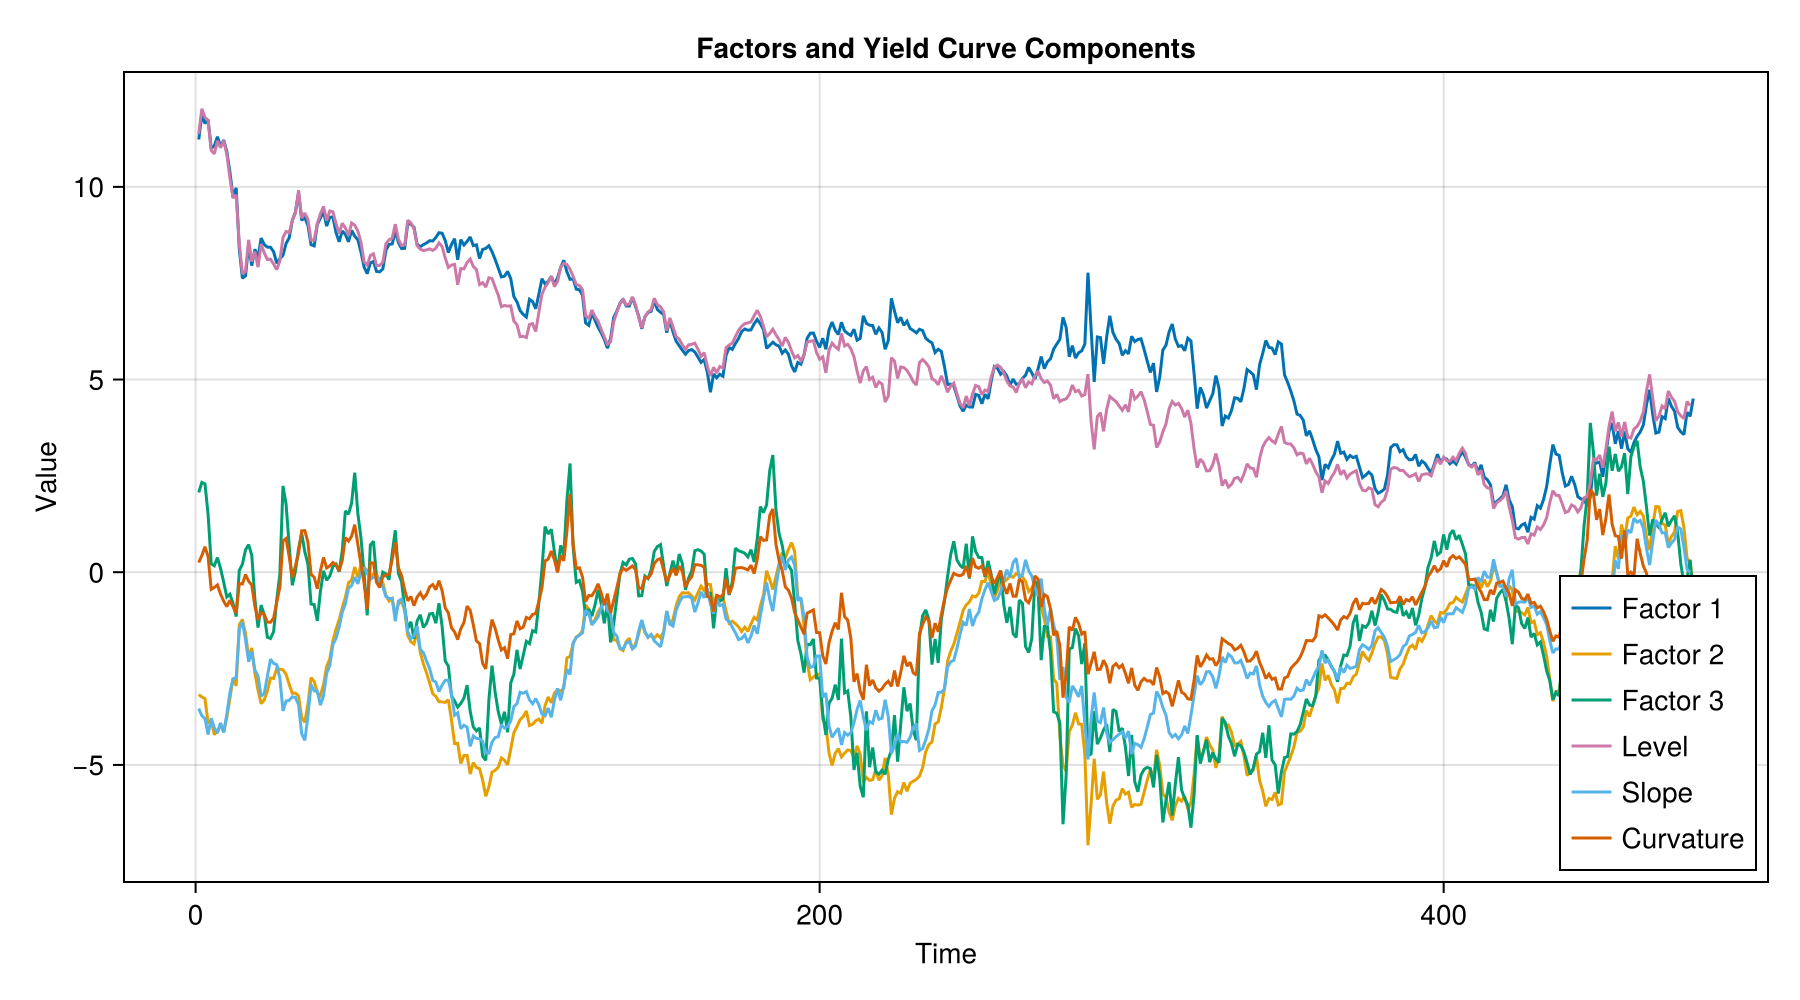

In [15]:
model_name = "SD-NS"
# read /Users/siccokooiker/surfdrive/JuliaProjects/YieldFactorModels.jl/results/SD-NS/SD-NS__thread_id__6__factors_filtered_outofsample.csv
filtered_data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__factors_filtered_outofsample.csv", ',')
# /Users/siccokooiker/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__data.csv
data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__data.csv", ',')
data = data'
# print shape
println(size(data))
println(size(filtered_data))

# plot first 3 factors over time using CairoMakie

f = Figure(resolution = (900, 500))
ax = Axis(f[1, 1], xlabel = "Time", ylabel = "Value", title = "Factors and Yield Curve Components")
lines!(ax, filtered_data[:, 1], label = "Factor 1")
lines!(ax, filtered_data[:, 2], label = "Factor 2")
lines!(ax, filtered_data[:, 3], label = "Factor 3")

# plot level, slope and curvature from data
# level is last column
lines!(ax, data[1:end-1, end], label = "Level")
# slope is difference between first and last column
lines!(ax, data[1:end-1, 1] .- data[1:end-1, end], label = "Slope")
# curvature: 2 x 14th column - (1st + last)
lines!(ax, 2 .* data[1:end-1, 14] .- (data[1:end-1, 1] .+ data[1:end-1, end]), label = "Curvature")

axislegend(ax, position = :rb)
f

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/siccokooiker/.julia/packages/Makie/4JW9B/src/scenes.jl:264


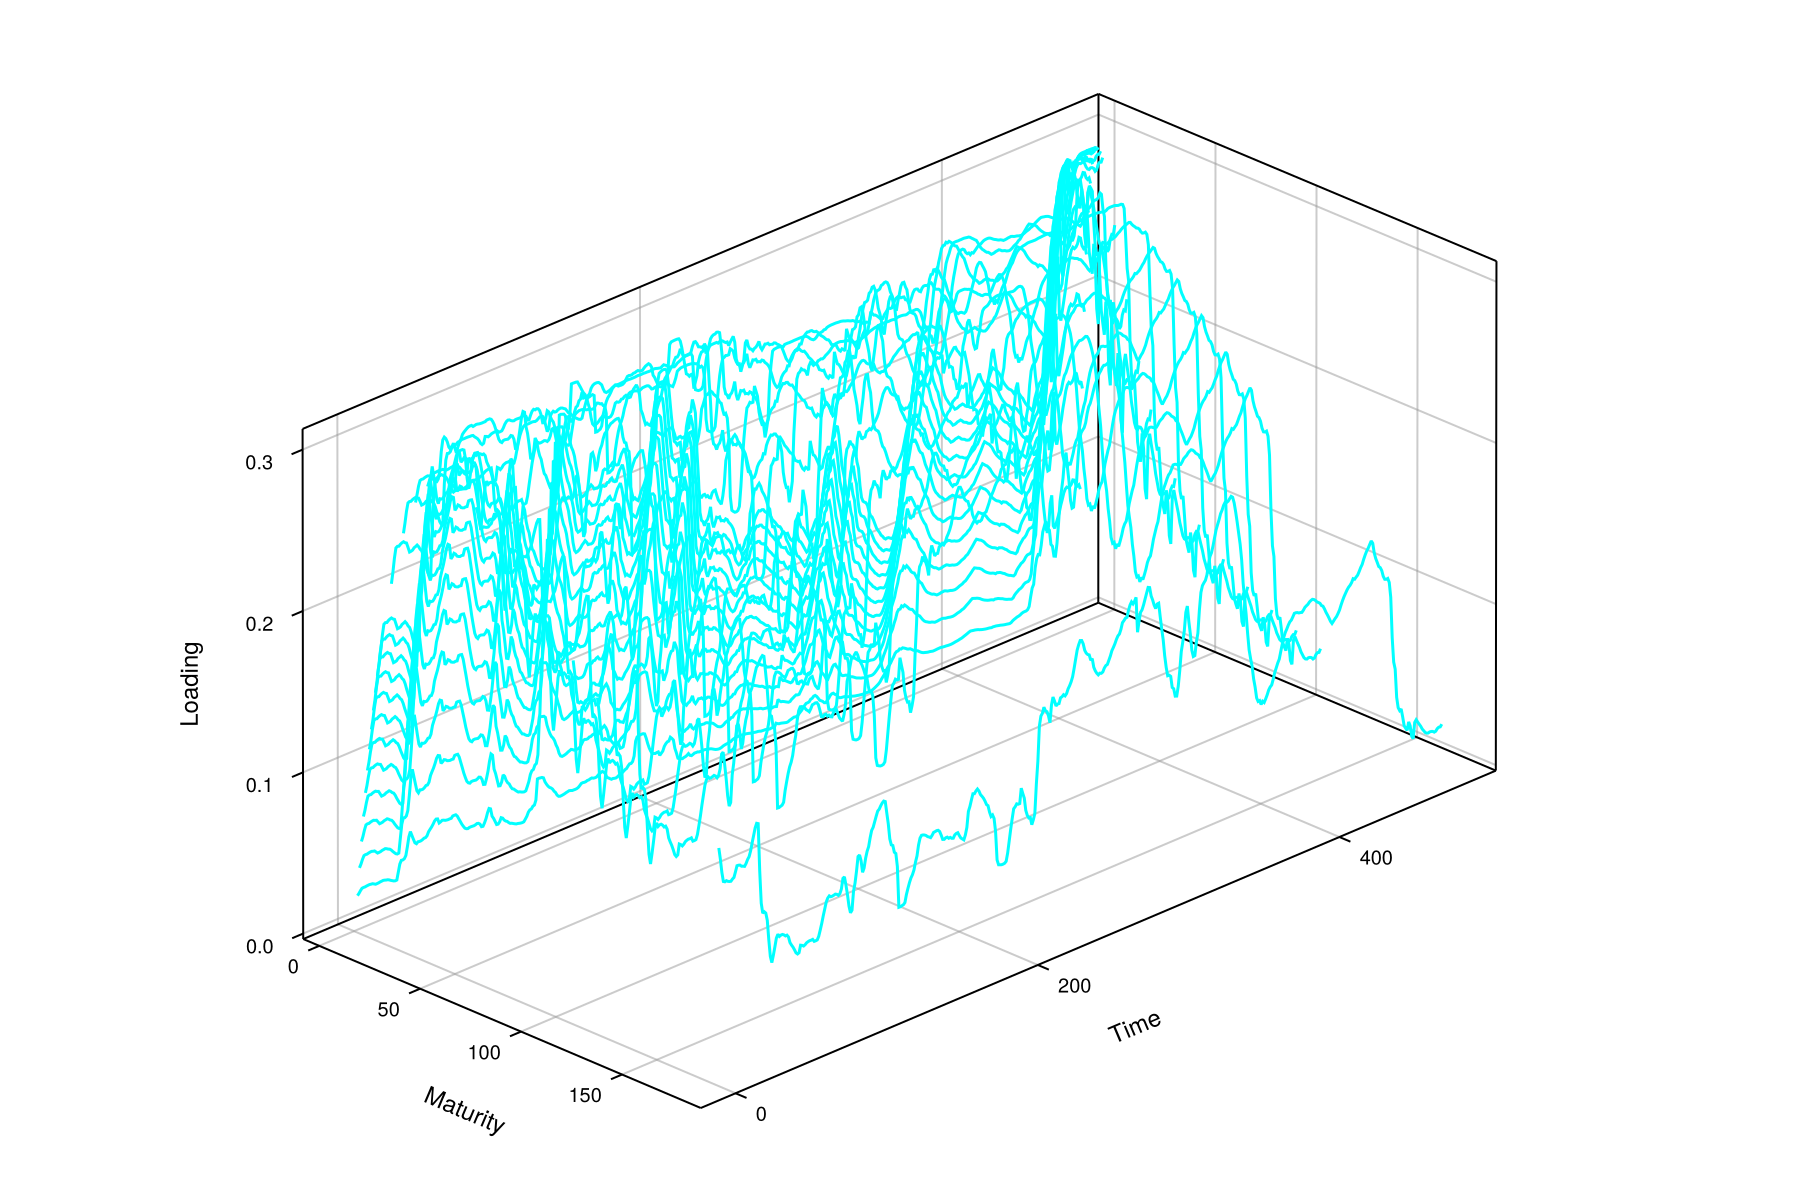

In [16]:


fac_path = "/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__factor_loadings_2_filtered_outofsample.csv"
mat_path = "/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/data/thread_id__6__maturities.csv"

Z = readdlm(fac_path, ',', Float64)      # (T × M)
Y = vec(readdlm(mat_path, ',', Float64)) # (M)
T, M = size(Z)
t = 1:T

# --- Create wireframe ---
fig = Figure(resolution = (900, 600))
ax = Axis3(fig[1, 1];
    xlabel="Time",
    ylabel="Maturity",
    zlabel="Loading",
    aspect=(2.0, 1.0, 1.0),  # Make time axis 2× as long as Y-axis
    elevation=25 * π / 180,
    azimuth=45 * π / 180,
    xreversed=true,
    backgroundcolor=:gray20,
    xgridcolor=(:gray60, 0.5),
    ygridcolor=(:gray60, 0.5),
    zgridcolor=(:gray60, 0.5),
    xticklabelsize=10,
    yticklabelsize=10,
    zticklabelsize=10,
    xlabelsize=12,
    ylabelsize=12,
    zlabelsize=12,

)

# draw lines for each maturity
for m in 1:M
    lines!(ax, t, fill(Y[m], T), Z[:, m], color=:cyan)
end
fig

(480, 24)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/siccokooiker/.julia/packages/Makie/4JW9B/src/scenes.jl:264


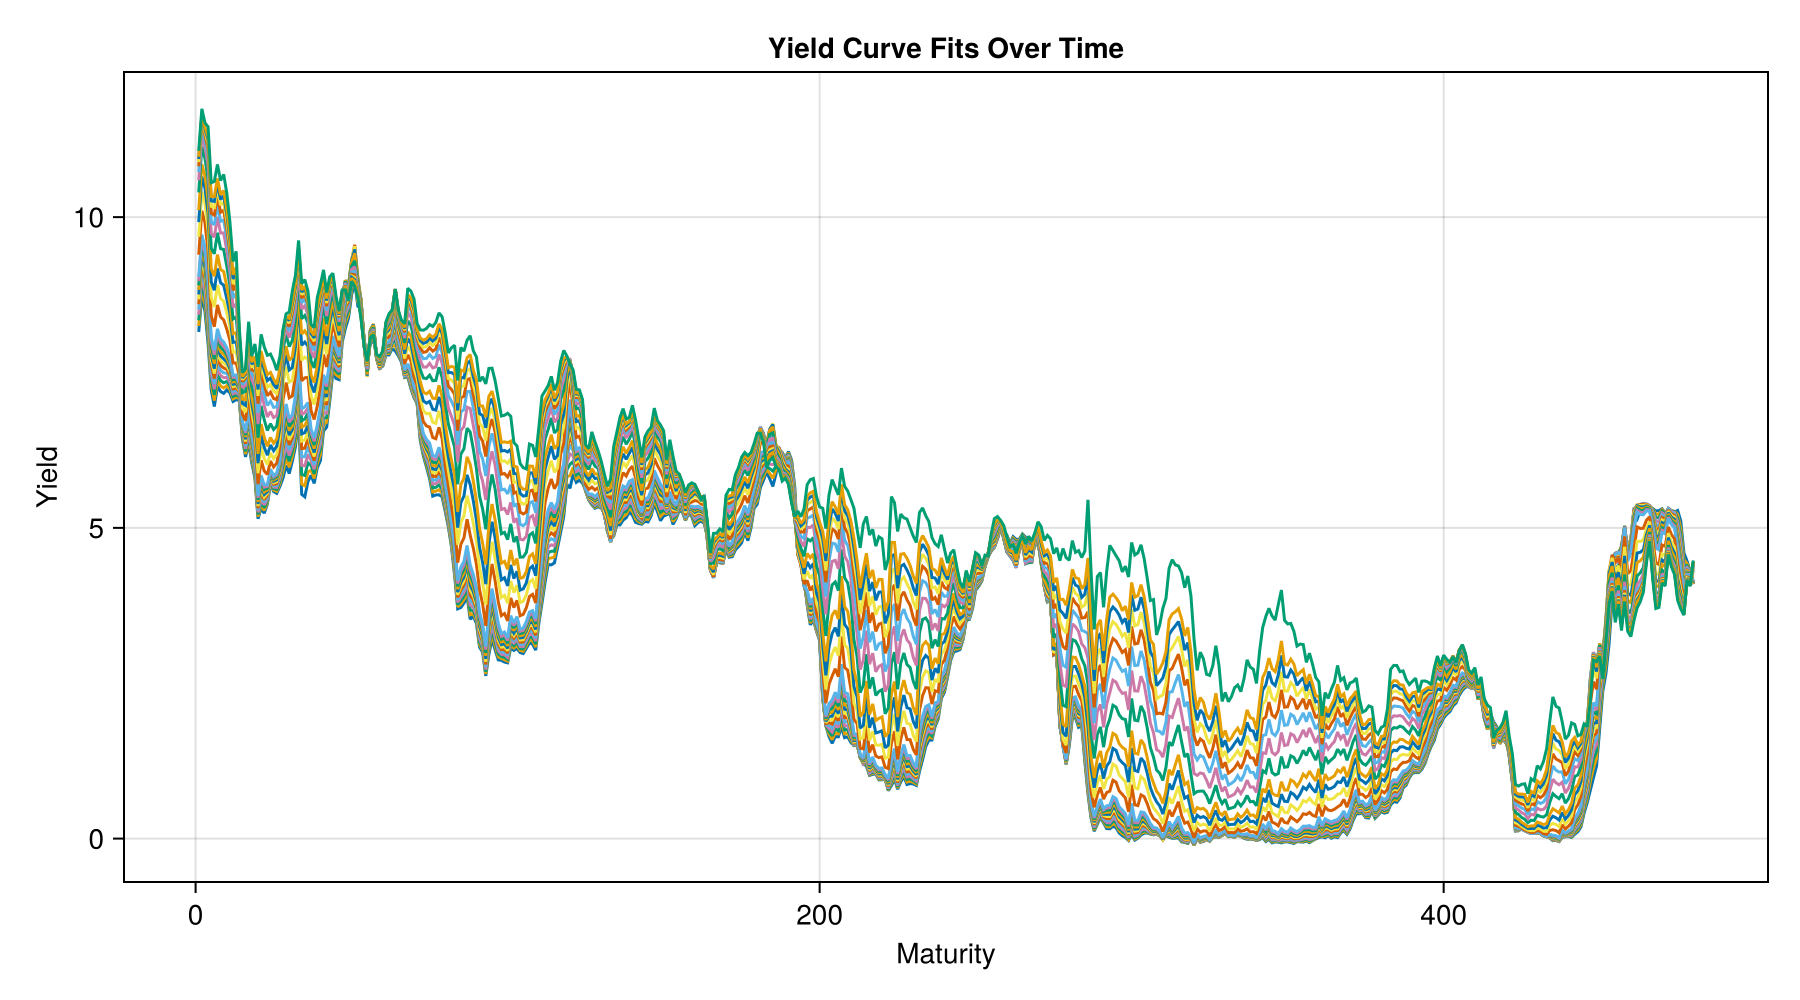

In [17]:
# plot predictions /Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/NS/NS__thread_id__6__fit_filtered_outofsample.csv
fit_data = readdlm("/Users/siccokooiker/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/surfdrive/JuliaProjects/YieldFactorModels.jl/results/$(model_name)/$(model_name)__thread_id__6__fit_filtered_outofsample.csv", ',')

# size is (480, 24)
println(size(fit_data))

# plot all 24 lines in one plot 
f2 = Figure(resolution = (900, 500))
ax2 = Axis(f2[1, 1], xlabel = "Maturity", ylabel = "Yield", title = "Yield Curve Fits Over Time")
for i in 1:size(fit_data, 2)
    lines!(ax2, 1:size(fit_data, 1), fit_data[:, i])
end
f2


## 5. Test `predict` Function

Test the full prediction over all time periods.

In [18]:
# Test predict function
println("Testing predict function...")
println("This function should return:")
println("  - Factors (M × T matrix)")
println("  - States (L × T matrix)")
println("  - Predictions (N × T matrix)")
println("  All stacked vertically: (M+L+N) × T")

# Note: Call with your actual model
# results = predict(model, data)
# println("\nExpected output shape: ", (M+L+N, T))
# println("Actual output shape: ", size(results))

Testing predict function...
This function should return:
  - Factors (M × T matrix)
  - States (L × T matrix)
  - Predictions (N × T matrix)
  All stacked vertically: (M+L+N) × T


## 6. Visualization (Optional)

Visualize the predictions vs actual data.

In [19]:
# Using Plots.jl for visualization
using Plots

# Plot actual yield data
plot(1:T, data[1, :], label="Yield 1 (actual)", 
     xlabel="Time", ylabel="Yield", 
     title="Yield Curve Data", linewidth=2)
plot!(1:T, data[3, :], label="Yield 3 (actual)", linewidth=2)
plot!(1:T, data[5, :], label="Yield 5 (actual)", linewidth=2)

ERROR: LoadError: UndefVarError: `SiunitxNumberFormatter` not defined in `LatexifyExt`
Stacktrace:
 [1] top-level scope
   @ ~/.julia/packages/Unitful/M33vg/ext/LatexifyExt.jl:51
 [2] include
   @ ./Base.jl:557 [inlined]
 [3] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base ./loading.jl:2881
 [4] top-level scope
   @ stdin:6
in expression starting at /Users/siccokooiker/.julia/packages/Unitful/M33vg/ext/LatexifyExt.jl:6
in expression starting at stdin:6
┌ Error: Error during loading of extension LatexifyExt of Unitful, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
Failed to precompile LatexifyExt [62c8d523-959e-58eb-864b-07d8b3b537d5] to "/Users/siccokooiker/.julia/compiled/v1.11/LatexifyExt/jl_rgOJrf".
Stacktrace:
  [1] error(s::String)
    @ Base ./error.jl:35
  [2] compileca

UndefVarError: UndefVarError: `plot` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in Makie.
Hint: a global variable of this name also exists in CairoMakie.
Hint: a global variable of this name also exists in Plots.

In [20]:
# After running predict, you can plot predictions vs actuals
# pred_start = M + L + 1
# predictions = results[pred_start:end, :]

# plot(1:T, data[1, :], label="Actual Yield 1", linewidth=2)
# plot!(1:T, predictions[1, :], label="Predicted Yield 1", 
#       linestyle=:dash, linewidth=2)
# title!("Actual vs Predicted Yields")

## 7. Performance and Diagnostics

In [21]:
# Calculate prediction errors
# residuals = data .- predictions
# mse_per_yield = mean(residuals.^2, dims=2)

# println("MSE per yield:")
# for i in 1:N
#     println("  Yield $i: ", mse_per_yield[i])
# end

In [22]:
# Plot factor evolution
# factors = results[1:M, :]

# plot(1:T, factors[1, :], label="Factor 1 (Level)", linewidth=2)
# plot!(1:T, factors[2, :], label="Factor 2 (Slope)", linewidth=2)
# plot!(1:T, factors[3, :], label="Factor 3 (Curvature)", linewidth=2)
# title!("Factor Evolution Over Time")
# xlabel!("Time")
# ylabel!("Factor Value")

## 8. Summary

This notebook demonstrates testing of the filter functionality. To fully run it, you'll need to:

1. Ensure your model type implements `AbstractYieldFactorModel`
2. Create a concrete model instance with appropriate parameters
3. Uncomment and run the actual function calls
4. Verify that all functions work correctly with your model structure